In [1]:
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import time
import matplotlib.pyplot as plt


In [2]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()
# model_ctx = mx.gpu()

In [3]:
batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              batch_size, shuffle=False)

In [4]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))

In [5]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=model_ctx)

In [6]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [7]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [8]:
# define evaluation function
def evaluate_accuracy(data_iterator, net, loss_fun):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        loss = loss_fun(output, label)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_avg

def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 1. Train Loss: 0.356979550138, Test Loss 0.340746513574, Train_acc 0.9012, Test_acc 0.9063, Take 6.1692647934 s
Completed epoch 3. Train Loss: 0.304811852414, Test Loss 0.293093169903, Train_acc 0.91495, Test_acc 0.9178, Take 6.07400012016 s
Completed epoch 5. Train Loss: 0.291989975043, Test Loss 0.28809627021, Train_acc 0.919133333333, Test_acc 0.9197, Take 6.09192419052 s
Completed epoch 7. Train Loss: 0.279449396503, Test Loss 0.277472854372, Train_acc 0.922116666667, Test_acc 0.9226, Take 6.18502402306 s
Completed epoch 9. Train Loss: 0.280041834105, Test Loss 0.278844280358, Train_acc 0.921833333333, Test_acc 0.9229, Take 6.12255215645 s


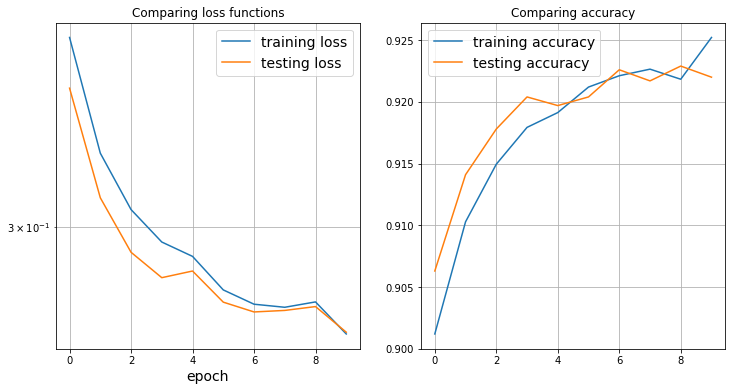

In [9]:
epochs = 10
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    start = time.time()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)
    end = time.time()
        
    test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 2 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s, Take %s s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy, (end-start)))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

Completed epoch 1. Train Loss: 0.633667311371, Test Loss 0.610412244774, Train_acc 0.853216666667, Test_acc 0.8639, Take 6.15001296997 s
Completed epoch 3. Train Loss: 0.45377284738, Test Loss 0.43287846522, Train_acc 0.882133333333, Test_acc 0.8898, Take 6.20016694069 s
Completed epoch 5. Train Loss: 0.405358843172, Test Loss 0.386602055068, Train_acc 0.8923, Test_acc 0.8982, Take 5.96767497063 s
Completed epoch 7. Train Loss: 0.379864108906, Test Loss 0.361839001061, Train_acc 0.896616666667, Test_acc 0.9029, Take 6.09772109985 s
Completed epoch 9. Train Loss: 0.364141402135, Test Loss 0.347108875751, Train_acc 0.900433333333, Test_acc 0.9054, Take 6.0113120079 s


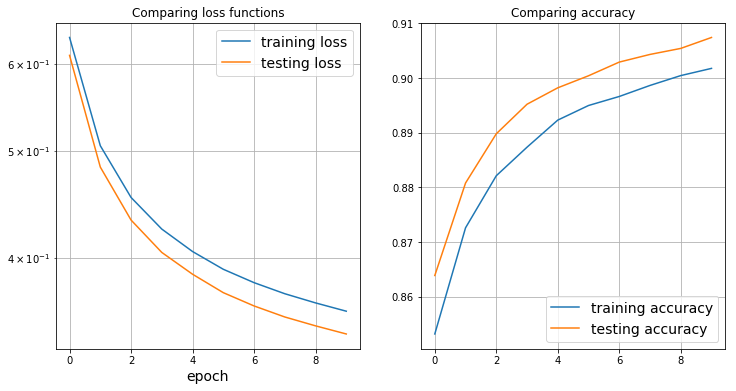

In [10]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=model_ctx, force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.001})

moving_loss = 0.
niter=0
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    start = time.time()
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)
    end = time.time()

    test_accuracy, test_loss = evaluate_accuracy(test_data, net,loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 2 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s, Take %s s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy, (end-start)))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)